In [57]:
#  In production mode we just load the best model and don't train it
# DEBUG_MODE = not(PRODUCTION_MODE)
PRODUCTION_MODE = True

In [58]:
!gdown --id '11awJD3GUiGgUJLHXS-4OIO3buNwKaxja'

Downloading...
From: https://drive.google.com/uc?id=11awJD3GUiGgUJLHXS-4OIO3buNwKaxja
To: /content/LSTM_trainable-010--0.262454.h5
100% 14.7M/14.7M [00:00<00:00, 44.8MB/s]


# Init

In [2]:
# https://medium.com/swlh/how-to-design-seq2seq-chatbot-using-keras-framework-ae86d950e91d

In [3]:
import io
import os
import re
import zipfile

import numpy as np
import requests
import yaml
from gensim.models import Word2Vec
from keras import Input, Model
from keras.activations import softmax
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.text import Tokenizer

from tensorflow.keras.callbacks import ModelCheckpoint
import keras
import matplotlib.pyplot as plt
#!pip install IPython
from IPython.display import clear_output as cls

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [40]:
from tensorflow.keras.initializers import Constant 

In [4]:
!gdown --id 1DeItE4GAV1sF_39aYxAz9qijZFJpfVYE # train set

Downloading...
From: https://drive.google.com/uc?id=1DeItE4GAV1sF_39aYxAz9qijZFJpfVYE
To: /content/dialogues_train.txt
100% 6.04M/6.04M [00:00<00:00, 27.5MB/s]


In [5]:
!gdown --id 1zIyapuv4_EHhPPqj9EHXy9XyigOssNvA # test/holdout set

Downloading...
From: https://drive.google.com/uc?id=1zIyapuv4_EHhPPqj9EHXy9XyigOssNvA
To: /content/dialogues_test.txt
100% 544k/544k [00:00<00:00, 4.06MB/s]


In [6]:
!gdown --id 1mGQGsFRV7cR4SuNddHSI5imYAJkgDjpo # val/dev

Downloading...
From: https://drive.google.com/uc?id=1mGQGsFRV7cR4SuNddHSI5imYAJkgDjpo
To: /content/dialogues_validation.txt
100% 558k/558k [00:00<00:00, 4.36MB/s]


In [7]:
def preprocess_sentence(sentence, max_len= 40):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # removing contractions
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "what is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  # remove extra spaces  " hi     man  " --> " hi man "
  sentence = re.sub(' +', ' ', sentence)
  sentence = sentence.strip()
  sentence = ' '.join(sentence.split(' ')[:max_len])
  return sentence

def read_dataset(path):
  text = []
  with open(path, 'r') as f:
    for line in f:
      line = line.rstrip()
      # print(line)
      res = line.split('__eou__')

      for i in range(0, len(res)-2):
        sent_1 = preprocess_sentence(res[i])
        sent_2 = preprocess_sentence(res[i+1])
        text.append(sent_1)
        text.append("<start> " + sent_2 + " <end>")
  
  return text

train_text = read_dataset('dialogues_train.txt')
test_text = read_dataset('dialogues_test.txt')
valid_text = read_dataset('dialogues_validation.txt')

train_text = train_text[:10000]
test_text = test_text[:10000]
valid_text = valid_text[:10000]

In [8]:
index = len(train_text)
train_questions = [train_text[i] for i in range(0,index) if i % 2 == 0]
train_answers = [train_text[i] for i in range(0,index) if i % 2 == 1]
train_pairs = [(train, test) for train, test in zip(train_questions, train_answers)]

index = len(valid_text)
dev_questions = [valid_text[i] for i in range(0,index) if i % 2 == 0]
dev_answers = [valid_text[i] for i in range(0,index) if i % 2 == 1]
val_pairs = [(train, test) for train, test in zip(dev_questions, dev_answers)]

In [9]:
len(train_answers) , len(dev_answers)

(5000, 5000)

In [10]:
train_questions[:5]

['say , jim , how about going for a few beers after dinner ?',
 'you know that is tempting but is really not good for our fitness .',
 'what do you mean ? it will help us to relax .',
 'do you really think so ? i do not . it will just make us fat and act silly . remember last time ?',
 'i guess you are right . but what shall we do ? i do not feel like sitting at home .']

In [11]:
train_answers[:5]

['<start> you know that is tempting but is really not good for our fitness . <end>',
 '<start> what do you mean ? it will help us to relax . <end>',
 '<start> do you really think so ? i do not . it will just make us fat and act silly . remember last time ? <end>',
 '<start> i guess you are right . but what shall we do ? i do not feel like sitting at home . <end>',
 '<start> i suggest a walk over to the gym where we can play singsong and meet some of our friends . <end>']

In [26]:
gensim_data = train_questions + train_answers + dev_answers + dev_questions

# Preparing data

# setting up Model

In [12]:
target_regex = '"#$%&()*+-/:;=@[\]^_`{|}~\t\n\'0123456789'
tokenizer = Tokenizer(filters=target_regex)
tokenizer.fit_on_texts(train_questions + train_answers)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print('Vocabulary size : {}'.format(VOCAB_SIZE))

Vocabulary size : 5032


In [21]:

print(len(tokenizer.word_index),'\n')
i = -1
for k,v in tokenizer.word_index.items():
  i +=1
  print(k,v)
  if i > 9: break

5031 

. 1
i 2
, 3
<start> 4
<end> 5
you 6
? 7
the 8
to 9
a 10
is 11


In [28]:
# tokenizer.index_word


# {1: '.',
#  2: 'i',
#  3: ',',
#  4: '<start>',
#  5: '<end>',
#  6: 'you',
#  7: '?',
#  8: 'the',
#  9: 'to',
#  10: 'a',
#  11: 'is',
#  12: 'it',
#  13: 'that',
#  14: 'and',

In [29]:
# Calculating W2V embedding wieghts 
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count
cores = cpu_count()

embedding_dim = 200


w2v = Word2Vec(
    size = embedding_dim,
    window = 10,
    min_count = 1,
    workers = cores,
    sg = 1
)


# we don't pass the first elemnt, padding token. we set its embedding zero
# watch out, build vocab gets list of iterable objects(like lists).
w2v.build_vocab([list(tokenizer.word_index.keys())])

w2v.train(
    sentences = gensim_data,
    total_examples = len(gensim_data),
    epochs = w2v.epochs )



(4597765, 6735165)

In [30]:
len(w2v.wv.vocab.keys())

5031

In [37]:
len()

5032

In [44]:
def embedding_matrix_maker(voc_s, emb_s,w2v_model,vocab_list):
  """
  note1: fist element of vocab list is '', which is our padding token
  and should have a zero vector as its embedding 
  """
  weights = np.zeros((voc_s, emb_s))
  for i in range(1,len(vocab_list)) :
    weights[i] = w2v_model.wv[vocab_list[i]].reshape(1, -1)[0]
    
  return weights 

embed_weights = embedding_matrix_maker(VOCAB_SIZE,
                                           embedding_dim,
                                           w2v,
                                           ['']+ list(tokenizer.word_index.keys()))



In [45]:
embed_weights.shape

(5032, 200)

In [32]:
max([len(x) for x in train_questions]) , [len(x) for x in train_questions].index(40)

(224, 70)

In [33]:
max([len(x.split(' ')) for x in train_questions]) 

40

In [34]:
tokenizer.word_index['<end>'],tokenizer.word_index['<start>'],tokenizer.word_index['.']

(5, 4, 1)

In [ ]:
##############################################################
############################ MODEL TRAINING ##################
##############################################################

In [35]:
tokenized_questions = tokenizer.texts_to_sequences(train_questions)
tokenized_answers = tokenizer.texts_to_sequences(train_answers)
decoder_input_data = []
decoder_output_data = []

for i in range(len(tokenized_answers)):
    decoder_output_data.append(tokenized_answers[i][1:])
    decoder_input_data.append(tokenized_answers[i][:-1])

maxlen_questions = max([len(x) for x in tokenized_questions]) # 40
maxlen_answers = max([len(x) for x in decoder_output_data]) # 40

encoder_input_data = pad_sequences(tokenized_questions, maxlen=maxlen_questions,padding='post')
decoder_input_data = pad_sequences(decoder_input_data, maxlen=maxlen_answers, padding='post')
decoder_output_data = pad_sequences(decoder_output_data, maxlen=maxlen_answers, padding='post')

print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_output_data.shape)

(5000, 40)
(5000, 41)
(5000, 41)


In [36]:
encoder_input_data[0]

array([ 103,    3,  524,    3,   44,   39,   70,   23,   10,  176, 2445,
        141,  248,    7,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [41]:
dev_tokenized_questions = tokenizer.texts_to_sequences(dev_questions)
dev_tokenized_answers = tokenizer.texts_to_sequences(dev_answers)
dev_decoder_input_data = []
dev_decoder_output_data = []

for i in range(len(dev_tokenized_answers)):
    dev_decoder_output_data.append(dev_tokenized_answers[i][1:])
    dev_decoder_input_data.append(dev_tokenized_answers[i][:-1])

# dev_maxlen_questions = max([len(x) for x in dev_tokenized_questions]) # 40
# dev_maxlen_answers = max([len(x) for x in dev_decoder_output_data]) # 41

dev_encoder_input_data = pad_sequences(dev_tokenized_questions, maxlen=maxlen_questions,padding='post')
dev_decoder_input_data = pad_sequences(dev_decoder_input_data, maxlen=maxlen_answers, padding='post')
dev_decoder_output_data = pad_sequences(dev_decoder_output_data, maxlen=maxlen_answers, padding='post')

print(dev_encoder_input_data.shape)
print(dev_decoder_input_data.shape)
print(dev_decoder_output_data.shape)

(5000, 40)
(5000, 41)
(5000, 41)


In [ ]:
# dev_tokenized_questions = tokenizer.texts_to_sequences(dev_questions)
# # maxlen_questions = max([len(x) for x in dev_tokenized_questions])
# dev_encoder_input_data = pad_sequences(dev_tokenized_questions, maxlen=maxlen_questions, padding='post')

# print(dev_encoder_input_data.shape)

# dev_tokenized_answers = tokenizer.texts_to_sequences(dev_answers)
# # maxlen_answers = max([len(x) for x in tokenized_answers])
# dev_decoder_input_data = pad_sequences(dev_tokenized_answers,
#                                    maxlen=maxlen_answers,
#                                    padding='post')
# print(dev_decoder_input_data.shape)

# for i in range(len(dev_tokenized_answers)):
#     dev_tokenized_answers[i] = dev_tokenized_answers[i][1:]

# dev_padded_answers = pad_sequences(dev_tokenized_answers, maxlen=maxlen_answers, padding='post')
# # decoder_output_data = to_categorical(padded_answers, VOCAB_SIZE)
# dev_decoder_output_data = dev_decoder_input_data

# print(dev_decoder_output_data.shape)

In [42]:
class PlotLosses(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.i = 0
    self.x = []
    self.losses= []
    self.val_losses = []
    self.fig = plt.figure()
    self.logs = []

    self.accuracy = []
    self.val_accuracy = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))    
    self.i +=1
    self.accuracy.append(logs.get('accuracy'))
    self.val_accuracy.append(logs.get('val_accuracy'))

    cls(wait=True)
    plt.plot(self.x, self.losses, label= 'loss')
    plt.plot(self.x, self.val_losses, label= 'val_loss')
    plt.legend()
    plt.show()

    plt.plot(self.x, self.accuracy, label= 'accuracy')
    plt.plot(self.x, self.val_accuracy, label= 'val_accuracy')
    plt.legend()
    plt.show()

# Trainable TRUE!

In [49]:

enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(
                      VOCAB_SIZE,
                      200, mask_zero=True,    
                      embeddings_initializer=Constant(embed_weights),
                      trainable=True,)(enc_inputs)

_, state_h, state_c = LSTM(200,
                           return_state=True)(enc_embedding)
enc_states = [state_h, state_c]

dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE,
                          200,
                          mask_zero=True,
                          embeddings_initializer=Constant(embed_weights),
                          trainable=True,)(dec_inputs)
dec_lstm = LSTM(200,
                return_state=True,
                return_sequences=True)
dec_outputs, _, _ = dec_lstm(dec_embedding,
                             initial_state=enc_states)
dec_dense = Dense(VOCAB_SIZE,
                  activation=softmax)
output = dec_dense(dec_outputs)

model = Model([enc_inputs, dec_inputs], output)


In [50]:
model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy',metrics=['accuracy'],)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 200)    1006400     ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, None, 200)    1006400     ['input_6[0][0]']                
                                                                                            

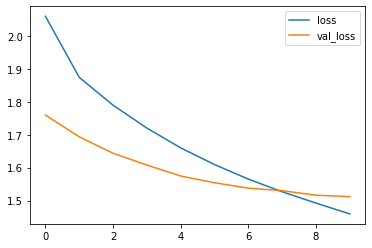

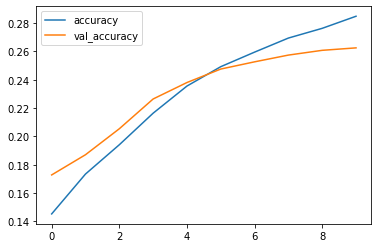

100/100 [==============================] - 99s 989ms/step - loss: 1.4594 - accuracy: 0.2848 - val_loss: 1.5119 - val_accuracy: 0.2625


In [51]:
if not PRODUCTION_MODE:
  plot_losses = PlotLosses()
  checkpoint = ModelCheckpoint('LSTM_trainable-{epoch:03d}--{val_accuracy:03f}.h5',
                             verbose=1, monitor='val_loss',save_best_only=True,
                             save_weights_only=True, mode='min')
  
  model.fit([encoder_input_data, decoder_input_data],
            decoder_output_data,
            batch_size=50,
            validation_data=([dev_encoder_input_data, dev_decoder_input_data],dev_decoder_output_data),
            epochs=10,
            callbacks= [checkpoint,plot_losses])


In [ ]:
# Epoch 8/10
# 100/100 [==============================] - 94s 942ms/step - loss: 1.5267 - accuracy: 0.2694 - val_loss: 1.5300 - val_accuracy: 0.2574
# Epoch 9/10
# 100/100 [==============================] - 98s 1s/step - loss: 1.4923 - accuracy: 0.2762 - val_loss: 1.5163 - val_accuracy: 0.2607
# Epoch 10/10
# 100/100 [==============================] - 99s 989ms/step - loss: 1.4594 - accuracy: 0.2848 - val_loss: 1.5119 - val_accuracy: 0.2625

# Trainable False!

In [52]:

enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(
                      VOCAB_SIZE,
                      200, mask_zero=True,    
                      embeddings_initializer=Constant(embed_weights),
                      trainable=False,)(enc_inputs)

_, state_h, state_c = LSTM(200,
                           return_state=True)(enc_embedding)
enc_states = [state_h, state_c]

dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE,
                          200,
                          mask_zero=True,
                          embeddings_initializer=Constant(embed_weights),
                          trainable=False,)(dec_inputs)
dec_lstm = LSTM(200,
                return_state=True,
                return_sequences=True)
dec_outputs, _, _ = dec_lstm(dec_embedding,
                             initial_state=enc_states)
dec_dense = Dense(VOCAB_SIZE,
                  activation=softmax)
output = dec_dense(dec_outputs)

model = Model([enc_inputs, dec_inputs], output)

In [53]:
model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy',metrics=['accuracy'],)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 200)    1006400     ['input_7[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, None, 200)    1006400     ['input_8[0][0]']                
                                                                                            

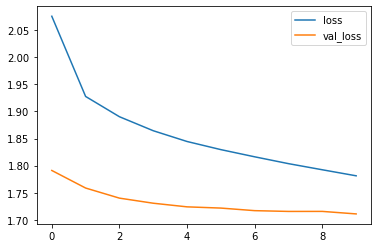

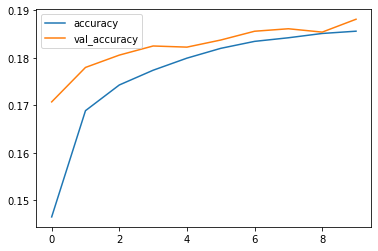

100/100 [==============================] - 91s 916ms/step - loss: 1.7812 - accuracy: 0.1856 - val_loss: 1.7108 - val_accuracy: 0.1881


In [54]:
if not PRODUCTION_MODE:
  plot_losses = PlotLosses()
  checkpoint = ModelCheckpoint('LSTM_non-trainable-{epoch:03d}--{val_accuracy:03f}.h5',
                             verbose=1, monitor='val_loss',save_best_only=True,
                             save_weights_only=True, mode='min')
  
  model.fit([encoder_input_data, decoder_input_data],
            decoder_output_data,
            batch_size=50,
            validation_data=([dev_encoder_input_data, dev_decoder_input_data],dev_decoder_output_data),
            epochs=10,
            callbacks= [checkpoint,plot_losses])


In [ ]:
# 100/100 [==============================] - 88s 880ms/step - loss: 1.7923 - accuracy: 0.1851 - val_loss: 1.7155 - val_accuracy: 0.1854
# Epoch 10/10
# 100/100 [==============================] 91s 916ms/step - loss: 1.7812 - accuracy: 0.1856 - val_loss: 1.7108 - val_accuracy: 0.1881

In [55]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
# %cp '/content/LSTM_trainable-010--0.262454.h5' '/content/drive/MyDrive/chatBot_momtazi/data/6'

# Trainable TURE or FALSE Comparison

"Trianbale-TRUE" outperforms "Trainable-FALSE" both in accuracy and val_loss. When we set "True" we are adopting "end-to-end" architecture which are proved to be better than "pipe-line" architecture. In pipe-line manner, we have different module and train them separately. They, however, might not work harmoniously. But when we trian the whole system as one module, we are free to adjust modules interfaces to reach higher overall accuracy.

As to time-complexity, "Trainable-FALSE" runs faster since has fewer number of parameters. 


.

# Load the best LSTM Model!

In [59]:
if PRODUCTION_MODE:
  model.load_weights('/content/LSTM_trainable-010--0.262454.h5')

In [ ]:
# %cp '/content/LSTM_Seq2Seq_chatbot_without_history.h5' '/content/drive/MyDrive/chatBot_momtazi/data/6'


# Q4

In [60]:
def make_inference_models():
    dec_state_input_h = Input(shape=(200,))
    dec_state_input_c = Input(shape=(200,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding,
                                             initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs=[dec_outputs] + dec_states)
    print('Inference decoder:')
    dec_model.summary()
    print('Inference encoder:')
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    enc_model.summary()
    return enc_model, dec_model

In [61]:

def str_to_tokens(sentence: str):
    words = sentence.lower().split()
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word, '')
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list],
                         maxlen=maxlen_questions,
                         padding='post')


In [62]:
enc_model, dec_model = make_inference_models()

Inference decoder:
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, None, 200)    1006400     ['input_8[0][0]']                
                                                                                                  
 input_9 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 200)]        0           []                               
                                                                         

In [63]:
test_cases = [
              'where have you been ?',
              'what is your name ?',
              'where are you from ?',
              'what do you want to drink ?',
]

In [ ]:
for s in test_cases:
  inp = s
  states_values = enc_model.predict(str_to_tokens(inp))
  empty_target_seq = np.zeros((1, 1))
  empty_target_seq[0, 0] = tokenizer.word_index['<start>']
  stop_condition = False
  decoded_translation = ''

  while not stop_condition:
      dec_outputs, h, c = dec_model.predict([empty_target_seq]
                                            + states_values)
      sampled_word_index = np.argmax(dec_outputs[0, -1, :])
      sampled_word = None
      for word, index in tokenizer.word_index.items():
          if sampled_word_index == index:
              if word != '<end>':
                  decoded_translation += ' {}'.format(word)
              sampled_word = word

      if sampled_word == '<end>' \
              or len(decoded_translation.split()) \
              > maxlen_answers:
          stop_condition = True

      empty_target_seq = np.zeros((1, 1))
      empty_target_seq[0, 0] = sampled_word_index
      states_values = [h, c]

  print(inp)
  print(decoded_translation)
  print('***************')

where have you been ?
 i am not sure .
***************
what is your name ?
 it is a little place , but i am not sure .
***************
where are you from ?
 i am not sure .
***************
what do you want to drink ?
 i am going to get a few times in the evening .
***************


# Question 5

I have already illustrated loss and accuracy for train and validation sets for both LSTM and Transformers.

LSTM takes around 100 seconds per epoch while transformers takes around 250 seconds per epoch. While both are trained on the same lenght train set, transformer has 5 times more parameter than LSTM. So, Considering the number of parameters, transformers run faster. This lies in thier capability to utilize multiprocessing. In fact, transformers treat the input data as a set of tokens, unlike LSTM that treat inputs as sequences. So, LSTM cannot utilize multiprocssing and parrallalization and this makes them slow.

In terms of accuracy, transformers with 31% accuracy outperform LSTM with 26%. This, in part, is on account of attention mechanism that transformers have.

Regarding val_los, LSTM, with 1.51 val_loss, perform better than transformer. This might be due to too many parameters of transformers. Perhaps, I should have used fewer number of encoder-decoder blocks.